In [ ]:
# Copyright 2019 Google LLC
# Copyright 2025 Anonymized Authors

# Licensed under the Apache License, Version 2.0 (the "License"); 
# you may not use this file except in compliance with the License. 
# You may obtain a copy of the License at
# https://www.apache.org/licenses/LICENSE-2.0
"""
This notebook benchmarks GENE and regularized evolution on NAS-Bench-101.
It uses a population size of 50 and mutation rate of 0.72 for RE. 

Requirements: 

-This notebook requires that  tensorflow and numpy be installed within the 
Python environment you are running this script in. 

"""
import json
import matplotlib.pyplot as plt
import os
import numpy as np
import random

import sys; sys.path.append('..')
from utils.nas_utils import load_nasbench,  NASBenchConstants, NASBench, SpecOneHot, init_pop, run_revolution_search
from utils.plotting import plot_all
from IPython.display import clear_output
from typing import Callable, List, Any

nasb = load_nasbench()


In [8]:
# we define our GENE algorithm: 

def greedy_selection(parents):
    """Selects greedy n parent pairs"""
    p_size = len(parents)
    population = np.asarray([p[0] for p in parents])

    summed_population = []
    for p1 in range(p_size):
        for p2 in range(p_size):
            if p1 < p2: # only upper triangle
                sum = population[p1] + population[p2]
            else:
                sum = 0
            summed_population.append(sum)

    samples = np.argsort(summed_population)[-p_size:]
    row_indices, col_indices = np.meshgrid(np.arange(p_size),np.arange(p_size))
    mapping = np.reshape(np.stack([col_indices,row_indices],axis=-1), [-1,2])
    pairings = mapping[samples]

    paired_parents = []
    for i in range(len(pairings)):
        p1 = parents[pairings[i,0]]
        p2 = parents[pairings[i,1]]
        paired_parents.append((p1,p2))

    return paired_parents


# crossover with random crossover point
def crossover(nasb, parents):
    """Performs vertical crossover on parent pairs, ensuring valid offspring."""
    
    def cross(p1, p2):
        if p1.original_matrix.shape != p2.original_matrix.shape:
            print("Shape mismatch")
            return p1

        for _ in range(5):
            i = random.randint(1, NASBenchConstants.NUM_VERTICES - 1)
            m = np.copy(p1.original_matrix)
            m[:i, :] = p2.original_matrix[:i, :]
            o = p1.original_ops[:i] + p2.original_ops[i:]
            new_spec = SpecOneHot(m, o)
            if nasb.is_valid(new_spec):
                return new_spec
        return p1

    return [cross(p[0][1], p[1][1]) for p in parents]

# guided mutation for nasbench specific encoding
def guided_mutation(nasb, population):
    psize = len(population)
    
    # Convert the inputs to NumPy arrays (assuming population is a list of objects with 'flat' attribute)
    inputs = [x.to_flat() for x in population]
    
    # Convert list of lists/arrays into a 2D NumPy array
    mutation_inputs = np.array(inputs)
    
    # Sum across the first axis (population size), axis=0 corresponds to summing across rows (for each feature)
    summed = np.sum(mutation_inputs, axis=0)

    # Define the probabilities for mutation
    probs_mat_1 = summed[:SpecOneHot.flat_matrix] / psize  # Mass of ones for flat matrix
    probs_mat_1 /= np.sum(probs_mat_1)  # Normalize so the sum of probabilities is 1
    probs_mat_0 = 1 - probs_mat_1  # Mass of zeros for flat matrix
    probs_mat_0 /= np.sum(probs_mat_0)  # Normalize so the sum of probabilities is 1

    probs_ops_1 = summed[SpecOneHot.flat_matrix:] / psize  # Mass of ones for operations
    probs_ops_1 /= np.sum(probs_ops_1)  # Normalize so the sum of probabilities is 1
    probs_ops_0 = 1 - probs_ops_1
    probs_ops_0 /= np.sum(probs_ops_0)  # Normalize so the sum of probabilities is 1

    children = []
    for i in range(psize):
        while True:
            child_spec = mutation_inputs[i, :].astype(int)

            # Select indices based on the probabilities using np.random.choice (similar to torch.multinomial)
            mat_index_1 = np.random.choice(len(probs_mat_0), 1, p=probs_mat_0)[0]
            mat_index_0 = np.random.choice(len(probs_mat_1), 1, p=probs_mat_1)[0]
            ops_index = np.random.choice(len(probs_ops_1), 1, p=probs_ops_1)[0] + SpecOneHot.flat_matrix

            # Modify the child_spec array based on the selected indices
            base = (ops_index - (ops_index % 3))  # Ensure base is aligned to 3 operations
            remove = [base, base + 1, base + 2]
            child_spec[remove] = 0
            child_spec[ops_index] = 1

            # set 0 to 1
            base2 = (mat_index_1 - (mat_index_1%2))
            remove2 = [base2, base2+1] 
            child_spec[remove2] = 0
            child_spec[base2] = 1

            # set 1 to 0
            base3 = (mat_index_0 - (mat_index_0%2))
            remove3 = [base3, base3+1] 
            child_spec[remove3] = 0
            child_spec[base3+1] = 1

            # Assuming SpecOneHot.spec_from_flat is a function that returns a spec from a flat representation
            spec = SpecOneHot.spec_from_flat(child_spec)
            
            if nasb.is_valid(spec):
                children.append(spec)
                break

    return children


def run_xevolution(
    nasbench: NASBench,
    selection_algorithm: Callable[[List], Any],
    crossover_algorithm: Callable[[NASBench, List], Any],
    mutation_algorithm: Callable[[NASBench, List], Any],
    max_time_budget=5e6,
    p_size=50,    
):
    """Run a single roll-out of evolution to a fixed time budget."""
    population, times, best_valids, best_tests = init_pop(nasbench, max_time_budget, p_size)
    while True:
        # generational approach: children replace old population
        selected_candidates = selection_algorithm(population)  
        crossed_parents = crossover_algorithm(nasbench, selected_candidates)
        children = mutation_algorithm(nasbench, crossed_parents)
        population = []
        for child in children: 
            data = nasbench.query(child)
            time_spent, _ = nasbench.get_budget_counters()
            times.append(time_spent)
            population.append((data["validation_accuracy"], child))
            if data["validation_accuracy"] > best_valids[-1]:
                best_valids.append(data["validation_accuracy"])
                best_tests.append(data["test_accuracy"])
            else:
                best_valids.append(best_valids[-1])
                best_tests.append(best_tests[-1])

        if time_spent> max_time_budget:
            break

    return times, best_valids, best_tests



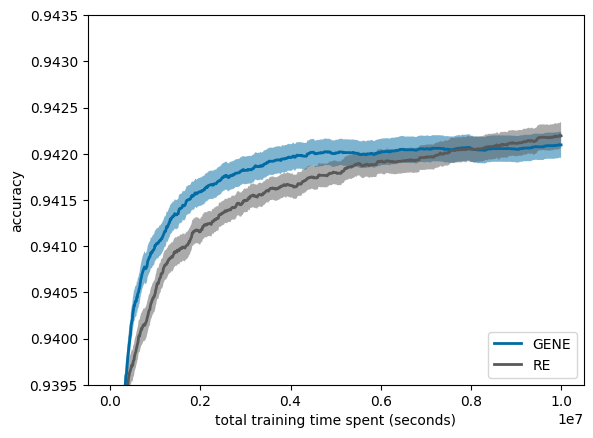

Running repeat 539


In [ ]:
# comparing GENE and regularized evolution

exp1 = {
    "data": 
    {
        "GENE" : [[],"Dark Blue"],
        "RE" : [[],"Very Dark Gray"],

    },
    "config": 
    {
        "budget" : int(1e7),
        "limits" : (0.9395, 0.9435),
        "n" : 1000,
        "print_every" : 2,
        "confidence_intervall" : True,
        "pvalue" : 0.05,
        "significant_areas": False,
        "dataset" : "test",
   }
}

budget = exp1["config"]["budget"]
for run in range(exp1["config"]["n"]):
    nasb.reset_budget_counters()
    times, best_valid, best_test = run_xevolution(nasb, greedy_selection, crossover, guided_mutation, budget, 50)
    exp1["data"]["GENE"][0].append((times, best_valid, best_test))

    nasb.reset_budget_counters()
    times, best_valid, best_test = run_revolution_search(nasb, budget, 50,10,0.72)
    exp1["data"]["RE"][0].append((times, best_valid, best_test))


    if (run % exp1["config"]["print_every"] == 0):
        clear_output(wait=True)
        fig, ax = plt.subplots()
        plot_all(exp1, ax)
        plt.show()
        print('Running repeat %d' % (run + 1))

clear_output(wait=True)
fig, ax = plt.subplots()
plot_all(exp1, ax)
plt.show()